# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run2_20', 'ORACLE.run2_44', 'ORACLE.run2_8', 'ORACLE.run2_50', 'ORACLE.run2_38', 'ORACLE.run2_14', 'ORACLE.run2_26', 'ORACLE.run2_32'}


{'ORACLE.run1_38', 'ORACLE.run1_50', 'ORACLE.run1_44', 'ORACLE.run1_26', 'ORACLE.run1_14', 'ORACLE.run1_20', 'ORACLE.run1_32', 'ORACLE.run1_8'}


tensor([[[ 3.2044e-03,  1.5564e-03, -3.9674e-03,  ..., -9.4607e-04,
           4.3336e-03, -1.8921e-03],
         [-1.8311e-04,  2.6246e-03, -2.4415e-04,  ..., -3.3265e-03,
          -3.2655e-03, -3.7233e-03]],

        [[-1.4039e-03,  1.9532e-03,  1.9532e-03,  ..., -3.2350e-03,
          -4.5473e-03, -1.9532e-03],
         [-3.0519e-03, -2.5636e-03,  3.6927e-03,  ...,  1.8311e-03,
          -1.6175e-03,  4.4252e-03]],

        [[-1.7701e-03, -2.5636e-03,  1.0071e-03,  ...,  3.6927e-03,
           3.3876e-03,  3.8759e-03],
         [ 3.9674e-03, -2.4415e-04, -4.5473e-03,  ...,  1.2818e-03,
           3.0519e-03, -3.1739e-03]],

        ...,

        [[-4.8524e-03, -3.3570e-04,  4.6999e-03,  ...,  0.0000e+00,
          -5.1881e-04,  4.7609e-03],
         [ 5.1881e-04, -2.7161e-03, -1.0376e-03,  ...,  3.7843e-03,
           3.8453e-03,  3.6622e-04]],

        [[ 2.1363e-03, -9.1556e-04, -2.2889e-03,  ...,  9.1556e-05,
           4.9440e-03,  3.6012e-03],
         [ 5.4933e-04,  4.1810e-0

In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 34.2536, train_label_loss: 2.6963, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 2831.5104, train_label_loss: 0.7426, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 2937.3395, train_label_loss: 0.5124, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 3029.7548, train_label_loss: 0.1585, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 2655.4055, train_label_loss: 0.1234, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 2599.4617, train_label_loss: 0.0888, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 2520.2889, train_label_loss: 0.1935, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 2559.4206, train_label_loss: 0.4067, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 2758.0698, train_label_loss: 0.4276, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 2898.1942, train_label_loss: 0.2556, 


epoch: 1, source_val_acc_label: 0.6396, target_val_acc_label: 0.6146, source_val_label_loss: 385.2448, target_val_label_loss: 395.0565, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 2.6141, train_label_loss: 500.3816, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3273.1257, train_label_loss: 9.8430, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 3432.0484, train_label_loss: 2.2187, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 3938.7013, train_label_loss: 0.2640, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 2850.7950, train_label_loss: 0.1434, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 2710.2186, train_label_loss: 1.4487, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3019.0569, train_label_loss: 4.8070, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3008.2702, train_label_loss: 0.2582, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 2987.6120, train_label_loss: 0.1156, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 2982.5359, train_label_loss: 0.3592, 


epoch: 2, source_val_acc_label: 0.8876, target_val_acc_label: 0.8712, source_val_label_loss: 0.3582, target_val_label_loss: 0.4076, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.7849, train_label_loss: 0.1730, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 3250.9894, train_label_loss: 0.3120, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 3440.7516, train_label_loss: 0.3467, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 3561.9564, train_label_loss: 0.1189, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 3024.3767, train_label_loss: 0.2817, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 2984.4719, train_label_loss: 0.0949, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 3018.6784, train_label_loss: 0.1579, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 3030.7965, train_label_loss: 0.1235, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 2967.6679, train_label_loss: 0.1181, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 2946.8255, train_label_loss: 0.2219, 


epoch: 3, source_val_acc_label: 0.9106, target_val_acc_label: 0.8893, source_val_label_loss: 0.2748, target_val_label_loss: 0.3517, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 2.8248, train_label_loss: 0.2813, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3252.9339, train_label_loss: 0.0973, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3405.9133, train_label_loss: 0.0486, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 3470.2955, train_label_loss: 0.1143, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 3015.6994, train_label_loss: 0.1481, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 2906.3115, train_label_loss: 0.1130, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 3006.8274, train_label_loss: 0.2558, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 2996.2560, train_label_loss: 0.2230, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 2708.6260, train_label_loss: 0.2008, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 2307.2898, train_label_loss: 0.3305, 


epoch: 4, source_val_acc_label: 0.9383, target_val_acc_label: 0.9139, source_val_label_loss: 0.1858, target_val_label_loss: 0.2927, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.0147, train_label_loss: 0.2302, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 2577.2577, train_label_loss: 0.1651, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 2603.8445, train_label_loss: 0.2348, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 2638.1795, train_label_loss: 0.2513, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 2597.2332, train_label_loss: 0.0089, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 2560.8684, train_label_loss: 0.1695, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 2572.4565, train_label_loss: 0.1321, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 2577.2331, train_label_loss: 0.3982, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 2642.6654, train_label_loss: 0.0630, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 2548.8971, train_label_loss: 0.3016, 


epoch: 5, source_val_acc_label: 0.9407, target_val_acc_label: 0.9167, source_val_label_loss: 0.1797, target_val_label_loss: 0.2825, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 2.3768, train_label_loss: 0.1792, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 2988.3235, train_label_loss: 0.1239, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 2959.8380, train_label_loss: 0.0336, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 3015.7154, train_label_loss: 0.0157, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 3435.0565, train_label_loss: 0.0456, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 3373.9218, train_label_loss: 0.1906, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 3365.0803, train_label_loss: 0.0060, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 3390.2726, train_label_loss: 0.1758, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3348.2681, train_label_loss: 0.0366, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 3518.3756, train_label_loss: 0.1012, 


epoch: 6, source_val_acc_label: 0.9382, target_val_acc_label: 0.9232, source_val_label_loss: 0.1918, target_val_label_loss: 0.2594, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.3770, train_label_loss: 0.1497, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 2272.9898, train_label_loss: 0.1299, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 2336.1435, train_label_loss: 0.1883, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 2329.8960, train_label_loss: 0.2910, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2320.9261, train_label_loss: 0.2406, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 2303.4194, train_label_loss: 0.3637, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 2286.5850, train_label_loss: 0.0412, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 2387.9443, train_label_loss: 0.1162, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 2618.5131, train_label_loss: 0.1420, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 2581.0770, train_label_loss: 0.2576, 


epoch: 7, source_val_acc_label: 0.9486, target_val_acc_label: 0.9233, source_val_label_loss: 0.1554, target_val_label_loss: 0.2679, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.0393, train_label_loss: 0.2566, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 2291.7541, train_label_loss: 0.1143, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 2298.2150, train_label_loss: 0.1128, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 2293.5069, train_label_loss: 0.0455, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2286.6561, train_label_loss: 0.1032, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 2307.2798, train_label_loss: 0.0129, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2309.5538, train_label_loss: 0.0586, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 2414.7072, train_label_loss: 0.2627, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 2938.3174, train_label_loss: 0.1743, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 2933.8240, train_label_loss: 0.2376, 


epoch: 8, source_val_acc_label: 0.9474, target_val_acc_label: 0.9198, source_val_label_loss: 0.1502, target_val_label_loss: 0.2696, 


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.3037, train_label_loss: 0.0741, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 2626.8029, train_label_loss: 0.0201, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 2870.7288, train_label_loss: 0.0660, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 2793.8874, train_label_loss: 0.0958, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 2337.5490, train_label_loss: 0.0588, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 2355.4090, train_label_loss: 0.1139, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 2331.4804, train_label_loss: 0.0266, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 2474.4392, train_label_loss: 0.0103, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 2606.7441, train_label_loss: 0.1056, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 2624.8528, train_label_loss: 0.1468, 


epoch: 9, source_val_acc_label: 0.9537, target_val_acc_label: 0.9205, source_val_label_loss: 0.1348, target_val_label_loss: 0.2725, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.0513, train_label_loss: 0.1679, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 2294.0188, train_label_loss: 0.1601, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 2314.8202, train_label_loss: 0.1314, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 2314.1935, train_label_loss: 0.0348, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 2312.4924, train_label_loss: 0.2240, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 2320.6496, train_label_loss: 0.0807, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 2317.2001, train_label_loss: 0.0478, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 2490.5876, train_label_loss: 1.3891, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 2663.5995, train_label_loss: 0.0216, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 2637.1713, train_label_loss: 0.0503, 


epoch: 10, source_val_acc_label: 0.9549, target_val_acc_label: 0.9230, source_val_label_loss: 0.1295, target_val_label_loss: 0.2636, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.2022, train_label_loss: 0.0103, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 2573.7903, train_label_loss: 0.0254, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 2556.1067, train_label_loss: 0.2659, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 2589.5958, train_label_loss: 0.0776, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 2647.7314, train_label_loss: 0.2874, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 2616.2409, train_label_loss: 0.1316, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 2977.1775, train_label_loss: 0.2924, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 2666.9935, train_label_loss: 0.0498, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 2608.1489, train_label_loss: 0.0139, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 2688.8364, train_label_loss: 0.0278, 


epoch: 11, source_val_acc_label: 0.9591, target_val_acc_label: 0.9246, source_val_label_loss: 0.1171, target_val_label_loss: 0.2787, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 2.0296, train_label_loss: 0.2185, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 2332.6045, train_label_loss: 0.0055, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 2331.9924, train_label_loss: 0.4857, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 2345.7576, train_label_loss: 0.0623, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 2310.9084, train_label_loss: 0.0491, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 2312.9371, train_label_loss: 0.1113, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 2352.4909, train_label_loss: 0.0232, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 2474.7619, train_label_loss: 0.1061, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 2593.5875, train_label_loss: 0.0472, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 2610.1483, train_label_loss: 0.0885, 


epoch: 12, source_val_acc_label: 0.9544, target_val_acc_label: 0.9219, source_val_label_loss: 0.1285, target_val_label_loss: 0.2698, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 2.3286, train_label_loss: 0.1429, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 2689.2389, train_label_loss: 0.2203, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 2662.1384, train_label_loss: 0.0320, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 2906.8259, train_label_loss: 0.0067, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 2892.2745, train_label_loss: 0.0257, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 2944.7097, train_label_loss: 0.0547, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3402.9168, train_label_loss: 0.2997, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 3420.8500, train_label_loss: 0.0187, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3597.0758, train_label_loss: 0.0310, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 3503.1968, train_label_loss: 0.1108, 


epoch: 13, source_val_acc_label: 0.9561, target_val_acc_label: 0.9198, source_val_label_loss: 0.1275, target_val_label_loss: 0.2867, 


epoch: 14, [batch: 1 / 6720], examples_per_second: 3.3493, train_label_loss: 0.0811, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 2941.1087, train_label_loss: 0.2787, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 2454.8169, train_label_loss: 0.1662, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 2309.0133, train_label_loss: 0.0371, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 2304.4748, train_label_loss: 0.1146, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 2301.2765, train_label_loss: 0.0134, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 2306.2981, train_label_loss: 0.0157, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 2303.4771, train_label_loss: 0.1068, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 2310.2880, train_label_loss: 0.2363, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 2322.4244, train_label_loss: 0.1130, 


epoch: 14, source_val_acc_label: 0.9582, target_val_acc_label: 0.9215, source_val_label_loss: 0.1245, target_val_label_loss: 0.2975, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 2.0996, train_label_loss: 0.0953, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 2637.2587, train_label_loss: 0.0616, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 2379.8220, train_label_loss: 0.0439, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 2313.3307, train_label_loss: 0.1180, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 2312.0384, train_label_loss: 0.2349, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 2311.7241, train_label_loss: 0.1512, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 2411.2553, train_label_loss: 0.0091, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 2595.6886, train_label_loss: 0.0307, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 2569.7289, train_label_loss: 0.0358, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 2611.3447, train_label_loss: 0.1202, 


epoch: 15, source_val_acc_label: 0.9583, target_val_acc_label: 0.9236, source_val_label_loss: 0.1164, target_val_label_loss: 0.2754, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

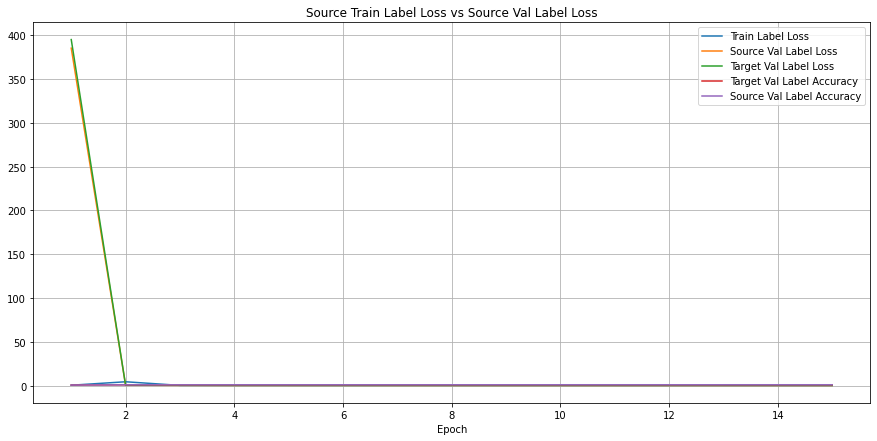

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

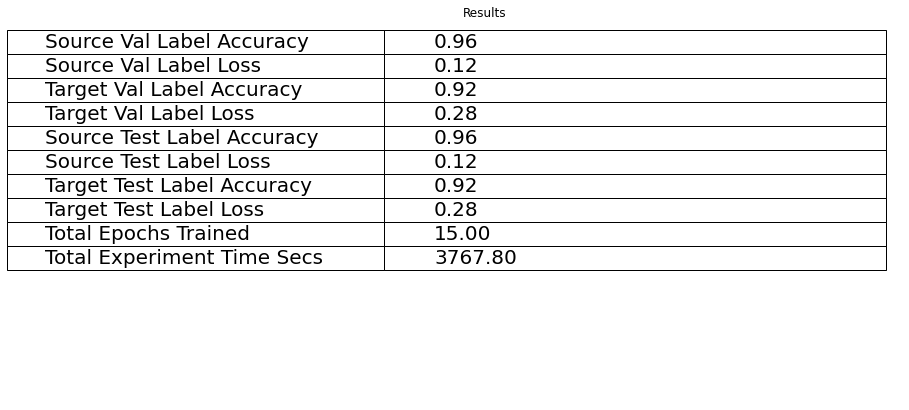

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

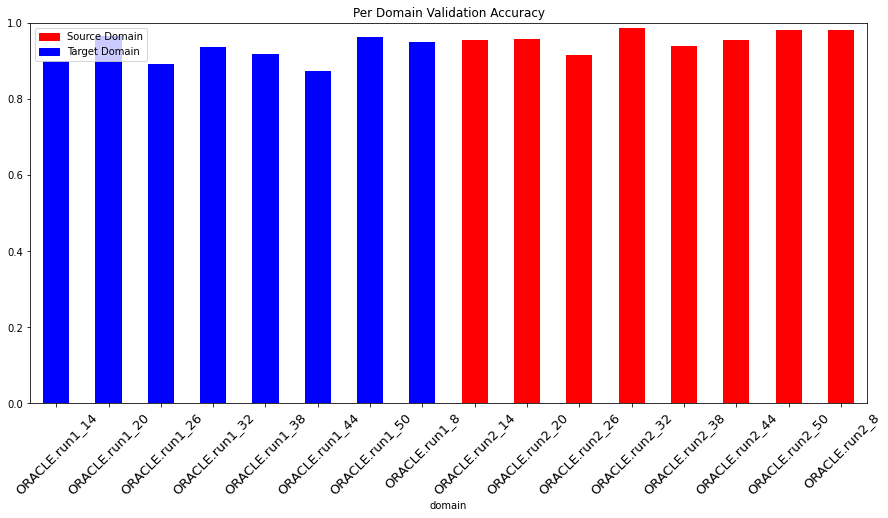

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9599609375 Target Test Label Accuracy: 0.9249348958333333
Source Val Label Accuracy: 0.9591145833333333 Target Val Label Accuracy: 0.9245768229166667


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 2048